In [1]:
import random
import numpy as np
import igraph as ig
import scipy as sp 
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score, rand_score,adjusted_rand_score


import scipy.linalg

import rpy2
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

import os
os.chdir('../')

import sys
# Add utils directory in the list of directories to look for packages to import
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))
from SpectralMethod import *

if not os.path.exists('./data/robustness'):
    os.makedirs('./data/robustness')
if not os.path.exists('./results/robustness/spectral'):
    os.makedirs('./results/robustness/spectral')
if not os.path.exists('./results/robustness/supernode'):
    os.makedirs('./results/robustness/supernode')


import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PYTHONWARNINGS']='ignore'

%load_ext rpy2.ipython


# Testing Robustness of Coarse Graining Methods

Test if CG methods are robust to the removal of random nodes using clustering metrics to compare the original coarse graining to the subsquent ones to node removal.

## Random removal of nodes

In [2]:
num_nodes = 1000
rem_nodes = 500
g = ig.Graph.Erdos_Renyi(num_nodes, 0.1)
A = g.get_adjacency_sparse().todense()
np.savetxt('./data/robustness/adj_0.txt',A)

In [3]:
def remove_n_nodes(adj_mat, n_removed):
    removed_nodes_index = []
    if n_removed > adj_mat.shape[0]:
        print('not enough nodes!')
    nodes_labels = np.arange(adj_mat.shape[0])
    np.random.shuffle(nodes_labels)
    for i in range(n_removed):
        new_adj_mat = np.delete(adj_mat, nodes_labels[:i], axis=0)
        new_adj_mat = np.delete(new_adj_mat, nodes_labels[:i], axis=1)
        np.savetxt(f'./data/robustness/adj_{i+1}.txt',new_adj_mat)
    np.savetxt(f'./data/robustness/removed_nodes.txt',nodes_labels)

In [4]:
remove_n_nodes(A,rem_nodes)

## Spectral method

In [7]:
import joblib
joblib.Parallel(n_jobs=10)(joblib.delayed(spectral_save)(np.loadtxt(f'./data/robustness/adj_{rem}.txt'), f'./results/robustness/spectral/spectral_{rem}.txt') for rem in range(rem_nodes));

## Super Node method

In [8]:
%%R
library('igraph')
source('./utils/SuperNode.R')

super_nodes <- 5
rem_nodes <- 500
rem_nodes <- rem_nodes-1
for (i in 0:rem_nodes){
    data <- as.matrix(read.table(paste0("./data/robustness/adj_",i,".txt")))
    network <- graph_from_adjacency_matrix(data, mode = c( "undirected"))
    #let's try 500 super nodes: plese feel free to change as you wish!
    SNOut=SuperNode(network, super_nodes)
    Node2SN=array(SNOut$SNAssn)
    write.table(SNOut$SNAssn, paste0("./results/robustness/supernode/supernodes_",i,".txt"), row.names = FALSE, col.names = FALSE)

}



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



## Test Robustness using NMI, RI, and ARI

In [9]:
removed_nodes_index = [int(x) for x in np.loadtxt(f'./data/robustness/removed_nodes.txt')]

spectral_results = [np.loadtxt(f'./results/robustness/spectral/spectral_{i}.txt') for i in range(rem_nodes)]
supernode_results = [np.loadtxt(f'./results/robustness/supernode/supernodes_{i}.txt') for i in range(rem_nodes)]

In [10]:
nmi_spectral = [normalized_mutual_info_score(np.delete(spectral_results[1], removed_nodes_index[:j+1]), spectral_results[j+2]) for j in range(rem_nodes-3)]
RI_spectral = [rand_score(np.delete(spectral_results[1], removed_nodes_index[:j+1]), spectral_results[j+2]) for j in range(rem_nodes-3)]
ARI_spectral = [adjusted_rand_score(np.delete(spectral_results[1], removed_nodes_index[:j+1]), spectral_results[j+2]) for j in range(rem_nodes-3)]

nmi_sn = [normalized_mutual_info_score(np.delete(supernode_results[1], removed_nodes_index[:j+1]), supernode_results[j+2]) for j in range(rem_nodes-3)]
RI_sn = [rand_score(np.delete(supernode_results[1], removed_nodes_index[:j+1]), supernode_results[j+2]) for j in range(rem_nodes-3)]
ARI_sn = [adjusted_rand_score(np.delete(supernode_results[1], removed_nodes_index[:j+1]), supernode_results[j+2]) for j in range(rem_nodes-3)]

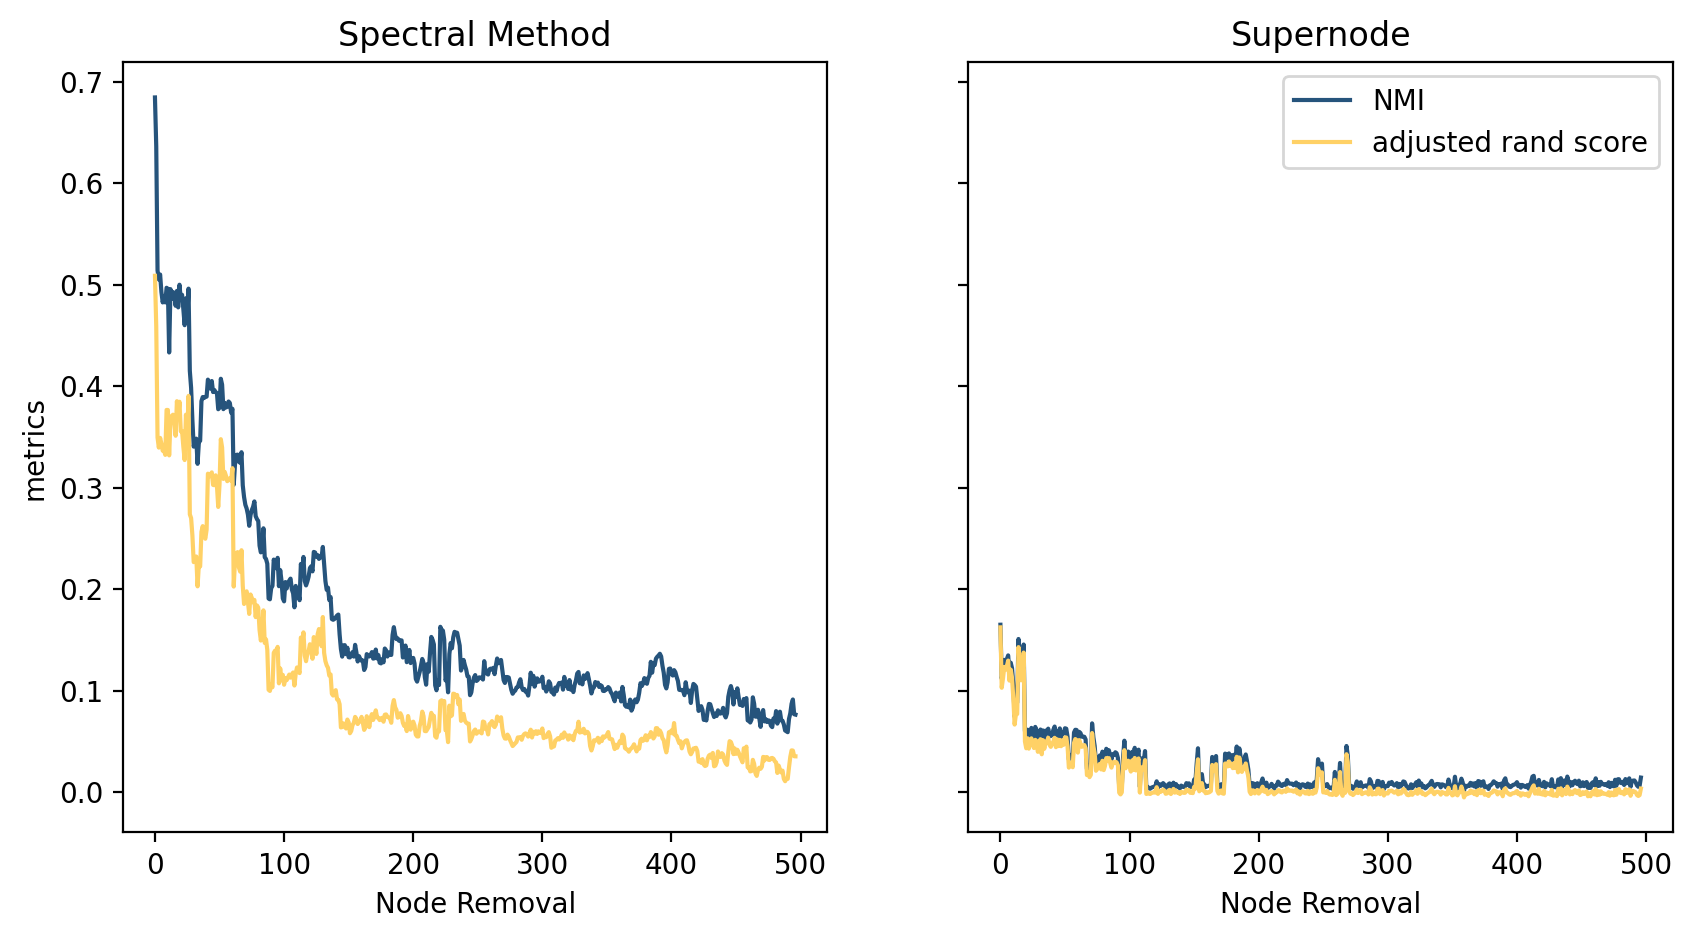

In [12]:
from matplotlib import pyplot as plt

fig , (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize =(10,5), dpi =200)

from matplotlib import pyplot as plt

palette = ['#26547c', '#ef476f', '#ffd166']
ax1.plot(nmi_spectral, label = 'NMI', color = palette[0])
#ax1.plot(RI_spectral, label = 'rand score', color = palette[1])
ax1.plot(ARI_spectral, label = 'adjusted rand score', color = palette[2])
ax1.set_ylabel('metrics')
ax1.set_xlabel('Node Removal')
ax1.set_title('Spectral Method')
#ax1.set_ylim(0,1)


ax2.plot(nmi_sn, label = 'NMI', color = palette[0])
#ax2.plot(RI_sn, label = 'rand score', color = palette[1])
ax2.plot(ARI_sn, label = 'adjusted rand score', color = palette[2])
#ax2.set_xlim(0,500)

ax2.set_title('Supernode')
#ax2.set_ylabel('metrics')
ax2.set_xlabel('Node Removal')
plt.legend()
plt.savefig('./figures/robustness.pdf')
plt.show()